In [1]:
import nibabel as nib
import noise
from fetalsyngen.generator.augmentation.artifacts import (
    SimulatedBoundaries,
    StructNoise,
    SimulateMotion,
    BlurCortex,
)
import os
import torch
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2   

In [2]:
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="configs/dataset/generator"):
    cfg = compose(config_name="default2.yaml")
print(OmegaConf.to_yaml(cfg))
syngen = hydra.utils.instantiate(cfg)

_target_: fetalsyngen.generator.model.FetalSynthGen
shape:
- 256
- 256
- 256
resolution:
- 0.5
- 0.5
- 0.5
device: cuda:0
intensity_generator:
  _target_: fetalsyngen.generator.intensity.rand_gmm.ImageFromSeeds
  min_subclusters: 1
  max_subclusters: 6
  seed_labels:
  - 0
  - 10
  - 11
  - 12
  - 13
  - 14
  - 15
  - 16
  - 17
  - 18
  - 19
  - 20
  - 21
  - 22
  - 23
  - 24
  - 25
  - 26
  - 27
  - 28
  - 29
  - 30
  - 31
  - 32
  - 33
  - 34
  - 35
  - 36
  - 37
  - 38
  - 39
  - 40
  - 41
  - 42
  - 43
  - 44
  - 45
  - 46
  - 47
  - 48
  - 49
  generation_classes:
  - 0
  - 10
  - 10
  - 10
  - 10
  - 10
  - 10
  - 10
  - 10
  - 10
  - 10
  - 20
  - 20
  - 20
  - 20
  - 20
  - 20
  - 20
  - 20
  - 20
  - 20
  - 30
  - 30
  - 30
  - 30
  - 30
  - 30
  - 30
  - 30
  - 30
  - 30
  - 40
  - 41
  - 42
  - 43
  - 44
  - 45
  - 46
  - 47
  - 48
  - 49
spatial_deform:
  _target_: fetalsyngen.generator.deformation.affine_nonrigid.SpatialDeformation
  device: ${..device}
  size: ${..shape}


In [64]:
base = "/media/tsanchez/tsanchez_data/data/fetal_dHCP/derivatives/sub-CC00861XX12/ses-43210/anat"
im = nib.load(os.path.join(base, "sub-CC00861XX12_ses-43210_desc-restore_T2w.nii.gz"))
segm = nib.load(os.path.join(base, "sub-CC00861XX12_ses-43210_desc-drawem9_dseg.nii.gz"))

artifacts = syngen.artifacts
artifacts = {"simulate_motion": artifacts["simulate_motion"]}
with torch.no_grad():
    artifacts_out = {}
    device = "cuda:0"
    output = torch.tensor(im.get_fdata()).to(device).squeeze()
    seg = torch.tensor(segm.get_fdata()).to(device).squeeze()
    for name, artifact in artifacts.items():
        print(name, artifact)
        if artifact is not None:
            output, metadata = artifact(
                output,
                seg,
                "cuda:0",
                {},
                resolution=[0.8, 0.8, 0.8],
            )
            artifacts_out[name] = metadata
    input_ = im.get_fdata()
    output = output.cpu().numpy()

simulate_motion <fetalsyngen.generator.augmentation.artifacts.SimulateMotion2 object at 0x707254154250>
{'smooth_volume_on': True, 'rm_slices_on': False, 'rm_slices_ratio': None, 'misreg_stack_on': [True, False], 'misreg_slice_on': False, 'merge_volume_on': False, 'ngaussians_merge': 3}


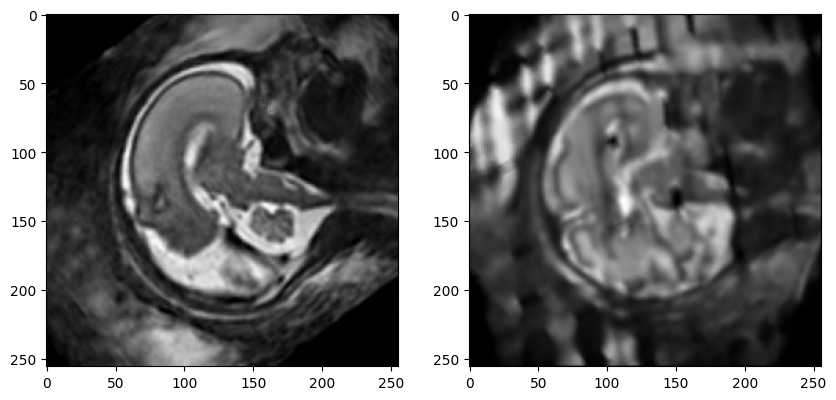

In [65]:
import matplotlib.pyplot as plt


f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_[125, ::-1,  ::-1],cmap="gray")
ax[1].imshow(output[125,  ::-1,  ::-1],cmap="gray")

In [66]:
import numpy as np
from fetalsyngen.generator.artifacts.utils import mog_3d_tensor


In [ ]:
def merge_mog(volume, volume_gt, vol_mask):
    device = volume.device
    pos = torch.where(vol_mask.squeeze() > 0)
    idx = torch.randperm(pos[0].shape[0])[: np.random.randint(1, 5)]

    centers = [(pos[0][i], pos[1][i], pos[2][i]) for i in idx]
    # Tested for an image of size 256^3
    sigmas = [
        torch.clamp(20 + 10 * torch.randn(1), 5, 40).to(device)
        for _ in range(len(centers))
    ]
    weight = mog_3d_tensor(
        volume.shape,
        centers=centers,
        sigmas=sigmas,
        device=device,
    ).view(*volume.shape)
    merged = weight * volume + (1 - weight) * volume_gt
    return merged, weight


merged, weight = merge_mog(torch.tensor(output).to(device), torch.tensor(input_).to(device), torch.tensor(seg>0).to(device))



To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
def merge_mog(volume, volume_gt, vol_mask):
    device = volume.device
    pos = torch.where(vol_mask.squeeze() > 0)
    idx = torch.randperm(pos[0].shape[0])[: np.random.randint(1, 5)]

    centers = [(pos[0][i], pos[1][i], pos[2][i]) for i in idx]
    # Tested for an image of size 256^3
    sigmas = [
        torch.clamp(20 + 10 * torch.randn(1), 5, 40).to(device)
        for _ in range(len(centers))
    ]
    weight = mog_3d_tensor(
        volume.shape,
        centers=centers,
        sigmas=sigmas,
        device=device,
    ).view(*volume.shape)
    merged = weight * volume + (1 - weight) * volume_gt
    return merged, weight


merged, weight = merge_mog(torch.tensor(output).to(device), torch.tensor(input_).to(device), torch.tensor(seg>0).to(device))



torch.Size([256, 256, 256])


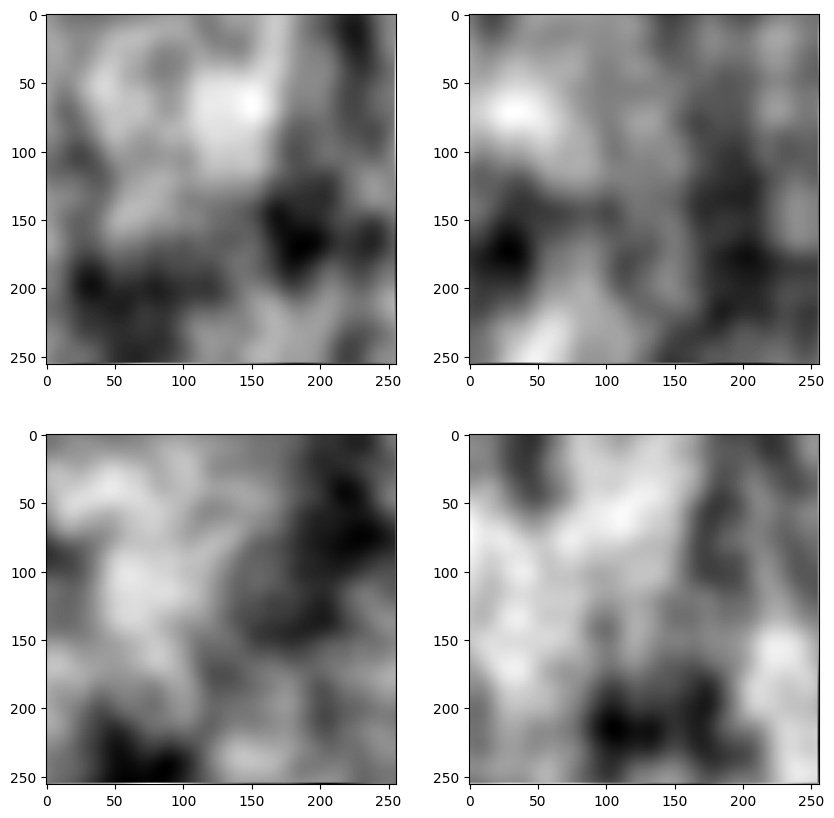

In [195]:
import torch

def interpolant(t):
    """Smoothstep interpolation function."""
    return t * t * t * (t * (t * 6 - 15) + 10)

def generate_perlin_noise_3d(shape, res, tileable=(False, False, False)):
    """
    Generate a 3D tensor of Perlin noise.
    
    Args:
        shape: Tuple of three ints, output shape.
        res: Tuple of three ints, number of periods in each axis.
        tileable: Tuple of three bools, if noise should tile.

    Returns:
        A PyTorch tensor with the generated noise.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    delta = (res[0] / shape[0], res[1] / shape[1], res[2] / shape[2])
    d = (shape[0] // res[0], shape[1] // res[1], shape[2] // res[2])

    grid = torch.stack(torch.meshgrid(
        torch.linspace(0, res[0], shape[0], device=device),
        torch.linspace(0, res[1], shape[1], device=device),
        torch.linspace(0, res[2], shape[2], device=device),
        indexing='ij'
    ), dim=-1) % 1  # Shape: (H, W, D, 3)

    # Gradients
    theta = 2 * torch.pi * torch.rand(res[0] + 1, res[1] + 1, res[2] + 1, device=device)
    phi = 2 * torch.pi * torch.rand(res[0] + 1, res[1] + 1, res[2] + 1, device=device)
    gradients = torch.stack((torch.sin(phi) * torch.cos(theta), 
                             torch.sin(phi) * torch.sin(theta), 
                             torch.cos(phi)), dim=-1)

    # Ensure tileability
    if tileable[0]:
        gradients[-1, :, :] = gradients[0, :, :]
    if tileable[1]:
        gradients[:, -1, :] = gradients[:, 0, :]
    if tileable[2]:
        gradients[:, :, -1] = gradients[:, :, 0]

    # Expand gradients for interpolation
    gradients = gradients.repeat_interleave(d[0], dim=0).repeat_interleave(d[1], dim=1).repeat_interleave(d[2], dim=2)

    # Compute dot products
    g000 = gradients[:-d[0], :-d[1], :-d[2]]
    g100 = gradients[d[0]:, :-d[1], :-d[2]]
    g010 = gradients[:-d[0], d[1]:, :-d[2]]
    g110 = gradients[d[0]:, d[1]:, :-d[2]]
    g001 = gradients[:-d[0], :-d[1], d[2]:]
    g101 = gradients[d[0]:, :-d[1], d[2]:]
    g011 = gradients[:-d[0], d[1]:, d[2]:]
    g111 = gradients[d[0]:, d[1]:, d[2]:]

    # Ramps
    n000 = (grid * g000).sum(dim=-1)
    n100 = ((grid - torch.tensor([1, 0, 0], device=device)) * g100).sum(dim=-1)
    n010 = ((grid - torch.tensor([0, 1, 0], device=device)) * g010).sum(dim=-1)
    n110 = ((grid - torch.tensor([1, 1, 0], device=device)) * g110).sum(dim=-1)
    n001 = ((grid - torch.tensor([0, 0, 1], device=device)) * g001).sum(dim=-1)
    n101 = ((grid - torch.tensor([1, 0, 1], device=device)) * g101).sum(dim=-1)
    n011 = ((grid - torch.tensor([0, 1, 1], device=device)) * g011).sum(dim=-1)
    n111 = ((grid - torch.tensor([1, 1, 1], device=device)) * g111).sum(dim=-1)

    # Interpolation
    t = interpolant(grid)
    n00 = n000 * (1 - t[..., 0]) + t[..., 0] * n100
    n10 = n010 * (1 - t[..., 0]) + t[..., 0] * n110
    n01 = n001 * (1 - t[..., 0]) + t[..., 0] * n101
    n11 = n011 * (1 - t[..., 0]) + t[..., 0] * n111
    n0 = n00 * (1 - t[..., 1]) + t[..., 1] * n10
    n1 = n01 * (1 - t[..., 1]) + t[..., 1] * n11
    noise = (1 - t[..., 2]) * n0 + t[..., 2] * n1

    return noise

def generate_fractal_noise_3d(shape, res, octaves=1, persistence=0.5, lacunarity=2, tileable=(False, False, False), device="cuda"):
    """Generate a 3D PyTorch tensor of fractal noise."""
    
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    noise = torch.zeros(shape, device=device)
    frequency = 1
    amplitude = 1

    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_3d(
            shape,
            (int(frequency * res[0]), int(frequency * res[1]), int(frequency * res[2])),
            tileable,
        )
        frequency *= lacunarity
        amplitude *= persistence

    return noise

# Example Usage
noise = generate_fractal_noise_3d((256, 256, 256), res=[2]*3, octaves=3, tileable=(False, False, False))
print(noise.shape)  # Should be (256, 256, 256)


f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(noise[125, :, :].cpu().numpy(), cmap="gray")
ax[0, 1].imshow(noise[:, 125, :].cpu().numpy(), cmap="gray")
ax[1, 0].imshow(noise[:, :, 125].cpu().numpy(), cmap="gray")
ax[1, 1].imshow(noise[40, :, :].cpu().numpy(), cmap="gray")

In [126]:
def gen_noise(x, y, z, scale=0.1, octaves=5, seed=None):
    """Generates a Perlin noise field of given size and scale."""
    seed = seed or np.random.randint(0, 100)
    noise_map = np.zeros((x,y,z))
    for i in range(x):
        for j in range(y):
            for k in range(z):
                noise_map[i][j][k] = noise.pnoise3(j * scale, i * scale, k*scale, octaves=6, persistence=0.5, lacunarity=2.0, repeatx=x, repeaty=y, repeatz=z,base=seed)
    
    # Normalize noise to [0,1]
    noise_map = (noise_map - noise_map.min()) / (noise_map.max() - noise_map.min())
    return noise_map

In [229]:
x,y,z = output.shape
#weight = gen_noise(x,y,z, scale=0.01, octaves=3, seed=0)
weight = generate_fractal_noise_3d((x,y,z), res=[2]*3, octaves=3, tileable=(False, False, False)).to("cpu").numpy()

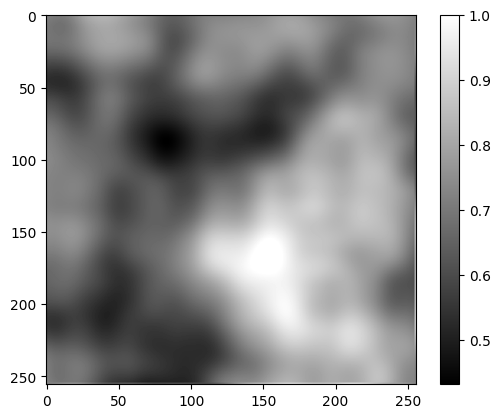

In [230]:
weight_norm = np.clip((weight + 0.3- weight.min()) / (weight.max() - weight.min()),0,1)
weight_norm = weight_norm / weight_norm.max()
plt.imshow(weight_norm[:,:,0], cmap="gray")
plt.colorbar()

In [231]:
merged = weight_norm * output + (1 - weight_norm) * input_


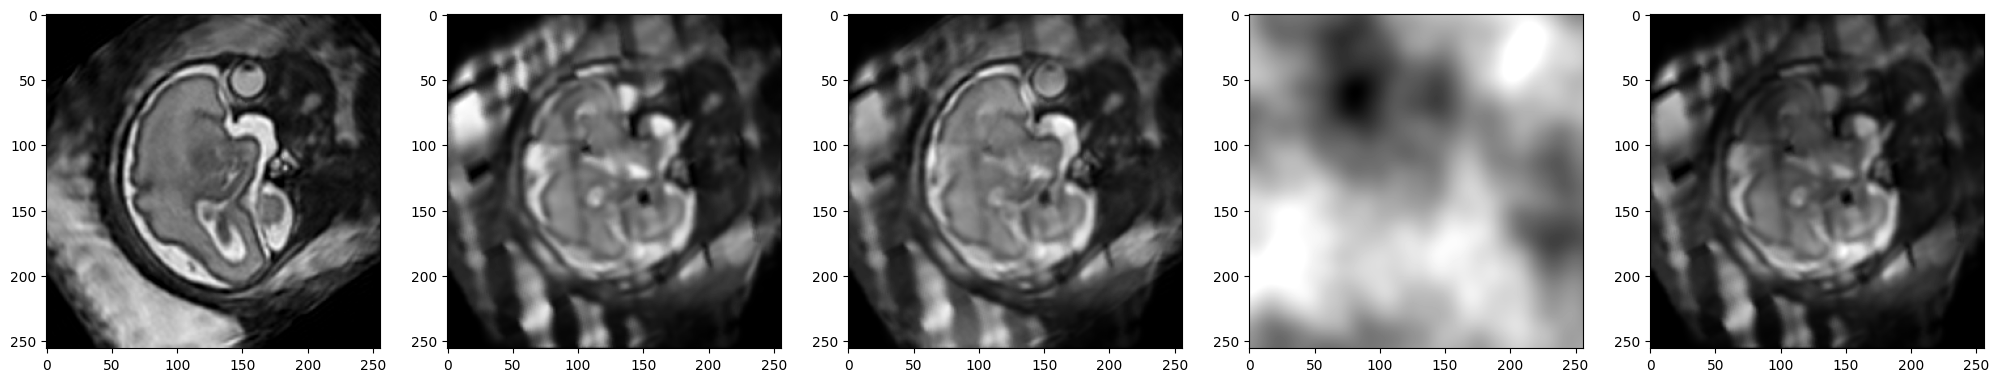

In [232]:
f, ax = plt.subplots(1, 5, figsize=(25, 5))
idx = 100
ax[0].imshow(input_[idx, ::-1, ::-1], cmap="gray")
ax[1].imshow(output[idx, ::-1, ::-1], cmap="gray")
ax[2].imshow(merged[idx, ::-1, ::-1], cmap="gray")
ax[3].imshow(weight_norm[idx, ::-1, ::-1], cmap="gray")
ax[4].imshow((weight_norm*output)[idx, ::-1, ::-1], cmap="gray")

In [138]:
# Save them as nibabel
nib.save(nib.Nifti1Image(weight * output + (1 - weight) * input_, im.affine), "merged.nii.gz")

nib.save(nib.Nifti1Image(weight_norm * output + (1 - weight_norm) * input_, im.affine), "merged2.nii.gz")
nib.save(nib.Nifti1Image(weight, im.affine), "weight.nii.gz")
nib.save(nib.Nifti1Image(output, im.affine), "output.nii.gz")
nib.save(nib.Nifti1Image(input_, im.affine), "input.nii.gz")
nib.save(nib.Nifti1Image((weight*output), im.affine), "merged_weighted.nii.gz")


In [39]:
base = "/media/tsanchez/tsanchez_data/data/fetal_dHCP/derivatives/sub-CC00861XX12/ses-43210/anat"
im = nib.load(os.path.join(base, "sub-CC00861XX12_ses-43210_desc-restore_T2w.nii.gz"))
segm = nib.load(os.path.join(base, "sub-CC00861XX12_ses-43210_desc-drawem9_dseg.nii.gz"))


def reo_im(im):
    return im.transpose(2, 1, 0)

with torch.no_grad():
    artifacts_out = {}
    device = "cuda:0"
    output = torch.tensor(reo_im(im.get_fdata())).to(device).squeeze()
    input_ =output.cpu().numpy()
    seg = torch.tensor(reo_im(segm.get_fdata().squeeze())).to(device).squeeze()
    for name, artifact in artifacts.items():
        print(name, artifact)
        if artifact is not None:
            output, metadata = artifact(
                output,
                seg,
                "cuda:0",
                {},
                resolution=[0.8, 0.8, 0.8],
            )
            artifacts_out[name] = metadata


output = output.cpu().numpy()

simulate_motion <fetalsyngen.generator.augmentation.artifacts.SimulateMotion2 object at 0x707254154250>
hi


ReconParams(prob_misreg_slice=0.1, slices_misreg_ratio=0.1, prob_misreg_stack=0.1, txy=3.0, prob_smooth=0.2, prob_rm_slices=0.3, rm_slices_min=0.1, rm_slices_max=0.4, prob_merge=0.8, merge_ngaussians_min=2, merge_ngaussians_max=4)

In [ ]:
SimulateMotion2a


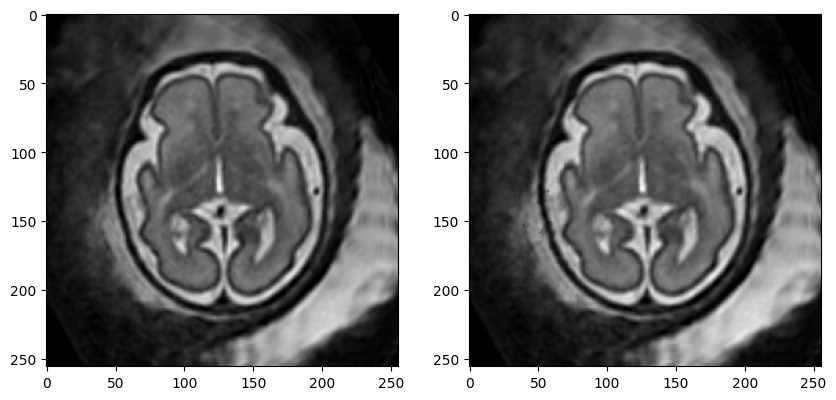

In [43]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_[125, ::-1, ::-1],cmap="gray")
ax[1].imshow(output[125, ::-1, ::-1],cmap="gray")
